# Detecting Anomalous Streams in the Language dataset

In [1]:
from __future__ import annotations
import random
import time
from typing import Callable

import numpy as np
import pandas as pd

import Data
from signature_mahalanobis_knn.utils import (
    compute_auc_given_dists,
    plot_cdf_given_dists,
)

from methods import (
    compute_signature_mahalanbois_knn_scores,
    compute_isolation_forest_scores_based_on_moments,
    compute_isolation_forest_scores_signatures,
    compute_local_outlier_factor_scores_based_on_moments,
    compute_local_outlier_factor_scores_signatures,
)

In [2]:
# ignore warnings from sktime about using iisignature backend
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore")

In [3]:
seed = 2023
random.seed(seed)
np.random.seed(seed)

bootstrap_samples = 10000

In [4]:
data = Data.Data(if_sample=False, random_seed=seed)

In [22]:
def language_dataset_experiment(
    data: Data.Data,
    anomaly_detection_method: Callable[[Data.Data], dict[str, np.array | float]],
    anomaly_detection_kwargs: dict | None = None,
    add_depth_to_kwargs: bool = False,
    plot: bool = False,
    plot_kwargs: dict | None = None,
) -> dict[str, np.array | float]:
    t0 = time.time()

    if anomaly_detection_kwargs is None:
        anomaly_detection_kwargs = {}
    if plot_kwargs is None:
        plot_kwargs = {}

    results_language_dataset = {
        "with_prefix": [],
        "auc": [],
        "se": [],
        "total_fit_time": [],
        "total_compute_score_time": [],
    }

    fit_times = []
    compute_times = []

    for with_prefix in [True, False]:
        # save hyperparameters for results
        results_language_dataset["with_prefix"].append(with_prefix)

        data.load_language_data(with_prefix=with_prefix)
        print(f"start with_prefix: {with_prefix}")

        if add_depth_to_kwargs:
            anomaly_detection_kwargs["depth"] = 2

        # compute the inlier and outlier scores
        results = anomaly_detection_method(data, **anomaly_detection_kwargs)

        # save fit and compute times
        fit_times.append(results["fit_time"])
        compute_times.append(results["compute_score_time"])

        # compute auc for digit
        auc = compute_auc_given_dists(
            results["scores_inliers"], results["scores_outliers"]
        )

        # plot and compute auc
        auc, se = compute_auc_given_dists(
            results["scores_inliers"],
            results["scores_outliers"],
            bootstrap=True,
            bootstrap_samples=bootstrap_samples,
            random_state=seed,
            plot=plot,
            title=f"Language Dataset (with prefix={with_prefix})",
        )

        # save results
        results_language_dataset["auc"].append(auc)
        results_language_dataset["se"].append(se)
        results_language_dataset["total_fit_time"].append(np.sum(fit_times))
        results_language_dataset["total_compute_score_time"].append(
            np.sum(compute_times)
        )

        if plot:
            # plot CDF
            plot_cdf_given_dists(
                results["scores_inliers"],
                results["scores_outliers"],
                bins=10000000,
                **plot_kwargs,
            )

        print(f"with prefix: {with_prefix} | auc: {auc} | se: {se}")

    total_time = time.time() - t0
    print(f"Total experiment time: {total_time} seconds | {total_time / 60} minutes")

    return results_language_dataset

## Signature Mahalanobis KNN

In [6]:
n_neighbours = 100

start with_prefix: True
fit_time: 12929.68161725998
compute_score_time: 133.17037892341614
with prefix: True | auc: 0.889933895


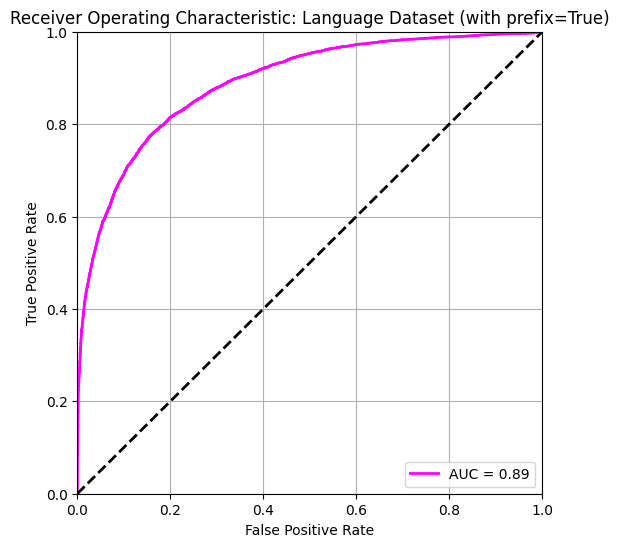

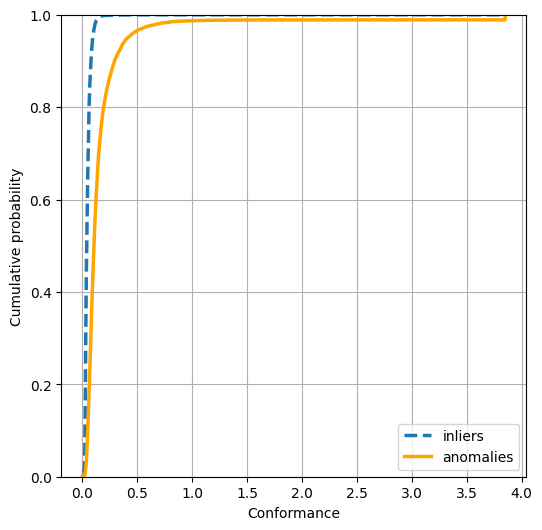

start with_prefix: False
fit_time: 12575.68718290329
compute_score_time: 129.70622277259827
with prefix: False | auc: 0.87747936


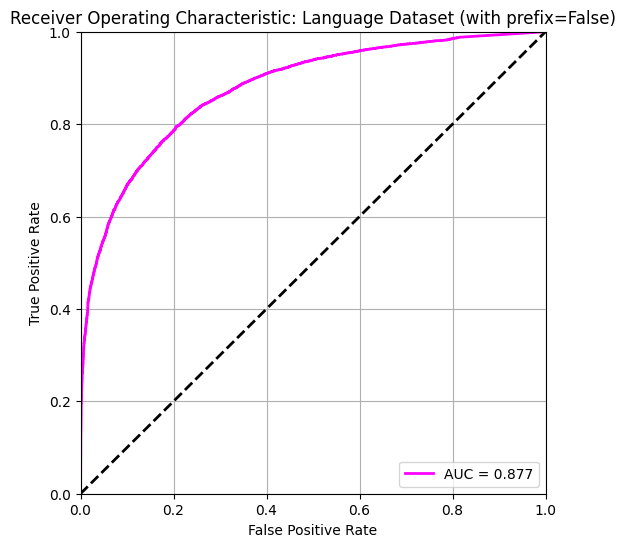

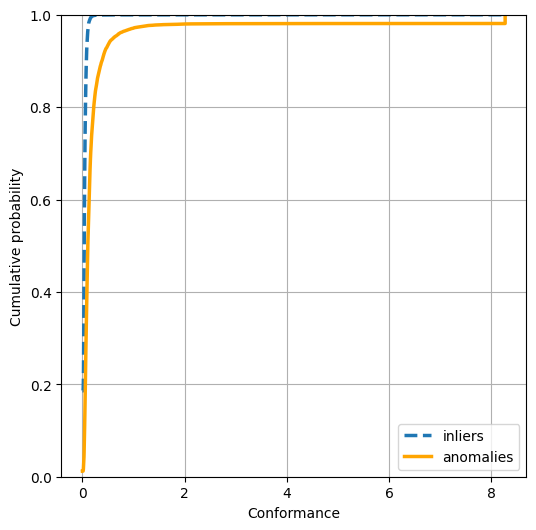

Total experiment time: 25880.424757003784 seconds | 431.34041261672974 minutes


In [7]:
results_language_dataset_signature_mahalanobis_knn = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_signature_mahalanbois_knn_scores,
    anomaly_detection_kwargs={
        "backend": "iisignature",
        "knn_library": "sklearn",
        "n_neighbours": n_neighbours,
        "random_state": seed,
    },
    add_depth_to_kwargs=True,
    plot=True,
    plot_kwargs=None,
)

In [17]:
pd.DataFrame(results_language_dataset_signature_mahalanobis_knn)

,auc,se,total_fit_time,total_compute_score_time,with_prefix
0,0.889934,0.002244,12929.681617,133.170379,True
1,0.877479,0.002386,25505.368800,262.876602,False


In [18]:
pd.DataFrame(results_language_dataset_signature_mahalanobis_knn).to_csv(
    "results/language_dataset_signature_mahalanobis_knn.csv"
)

## Baseline: Isolation Forest

### Using moments as features

In [23]:
results_language_dataset_isolation_forest_moments = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_isolation_forest_scores_based_on_moments,
    anomaly_detection_kwargs={"random_state": seed},
    add_depth_to_kwargs=False,
    plot=False,
    plot_kwargs=None,
)

start with_prefix: True
fit_time: 0.1220090389251709
compute_score_time: 0.07168197631835938
with prefix: True | auc: 0.7051954349999999 | se: 0.0036900996389149453
start with_prefix: False
fit_time: 0.10636305809020996
compute_score_time: 0.07176589965820312
with prefix: False | auc: 0.7229885650000001 | se: 0.0036416616994392158
Total experiment time: 117.78209710121155 seconds | 1.963034951686859 minutes


In [24]:
pd.DataFrame(results_language_dataset_isolation_forest_moments)

,with_prefix,auc,se,total_fit_time,total_compute_score_time
0,True,0.705195,0.003690,0.122009,0.071682
1,False,0.722989,0.003642,0.228372,0.143448


In [25]:
pd.DataFrame(results_language_dataset_isolation_forest_moments).to_csv(
    "results/language_dataset_isolation_forest_moments.csv"
)

### Using path signatures as features

In [26]:
results_language_dataset_isolation_forest_signatures = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_isolation_forest_scores_signatures,
    anomaly_detection_kwargs={"backend": "iisignature", "random_state": seed},
    add_depth_to_kwargs=True,
    plot=False,
    plot_kwargs=None,
)

start with_prefix: True
fit_time: 0.20020198822021484
compute_score_time: 0.16024494171142578
with prefix: True | auc: 0.7318700800000001 | se: 0.0035683318883464243
start with_prefix: False
fit_time: 0.12604403495788574
compute_score_time: 0.10890507698059082
with prefix: False | auc: 0.7310202100000001 | se: 0.003581606307013908
Total experiment time: 160.24441504478455 seconds | 2.6707402507464093 minutes


In [27]:
pd.DataFrame(results_language_dataset_isolation_forest_signatures)

,with_prefix,auc,se,total_fit_time,total_compute_score_time
0,True,0.73187,0.003568,0.200202,0.160245
1,False,0.73102,0.003582,0.326246,0.269150


In [28]:
pd.DataFrame(results_language_dataset_isolation_forest_signatures).to_csv(
    "results/language_dataset_isolation_forest_signatures.csv"
)

## Baseline: Local Outlier Factor


### Using moments as features

In [29]:
results_language_dataset_local_outlier_factor_moments = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_local_outlier_factor_scores_based_on_moments,
    anomaly_detection_kwargs={"n_neighbors": n_neighbours},
    add_depth_to_kwargs=False,
    plot=False,
    plot_kwargs=None,
)

start with_prefix: True
fit_time: 23.063555002212524
compute_score_time: 0.00021028518676757812
with prefix: True | auc: 0.696183475 | se: 0.0037071609347127223
start with_prefix: False
fit_time: 23.183524131774902
compute_score_time: 0.00027823448181152344
with prefix: False | auc: 0.746562 | se: 0.003467639636816925
Total experiment time: 167.48186802864075 seconds | 2.7913644671440125 minutes


In [30]:
pd.DataFrame(results_language_dataset_local_outlier_factor_moments)

,with_prefix,auc,se,total_fit_time,total_compute_score_time
0,True,0.696183,0.003707,23.063555,0.000210
1,False,0.746562,0.003468,46.247079,0.000489


In [31]:
pd.DataFrame(results_language_dataset_local_outlier_factor_moments).to_csv(
    "results/language_dataset_local_outlier_factor_moments.csv"
)

### Using path signatures as features

In [32]:
results_language_dataset_local_outlier_factor_signatures = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_local_outlier_factor_scores_signatures,
    anomaly_detection_kwargs={"backend": "iisignature", "n_neighbors": n_neighbours},
    add_depth_to_kwargs=True,
    plot=False,
    plot_kwargs=None,
)

start with_prefix: True
fit_time: 47.30217504501343
compute_score_time: 3.2901763916015625e-05
with prefix: True | auc: 0.7870619050000001 | se: 0.003254721440392075
start with_prefix: False
fit_time: 41.211479902267456
compute_score_time: 0.000213623046875
with prefix: False | auc: 0.790625405 | se: 0.003211425150444873
Total experiment time: 254.18011498451233 seconds | 4.236335249741872 minutes


In [33]:
pd.DataFrame(results_language_dataset_local_outlier_factor_signatures)

,with_prefix,auc,se,total_fit_time,total_compute_score_time
0,True,0.787062,0.003255,47.302175,0.000033
1,False,0.790625,0.003211,88.513655,0.000247


In [34]:
pd.DataFrame(results_language_dataset_local_outlier_factor_signatures).to_csv(
    "results/language_dataset_local_outlier_factor_signatures.csv"
)